In [3]:
from scgenome.tantalus import get_data
from scgenome.qc import qc_cn
from IPython.display import display

hmmcopy_tickets = [
#     'SC-1935',
    'SC-1936',
#     'SC-1937',
]

sample_ids = [
#     'SA922',
    'SA921', 
#     'SA1090',
]

data = get_data(hmmcopy_tickets, sample_ids, cached=True)
cn_data = data[0]
segs_data = data[1]
metrics_data = data[2]
align_metrics_data = data[3]

print("cn_data.head()")
display(cn_data.head())

#cn = qc_cn(metrics_data, cn_data)
#print("cn.head()")
#display(cn.head())

2019-09-05 10:11:23,807 - INFO - b4562e0d-6a5a-4b7e-a228-1b611763c571 - TokenRequest:Getting token with client credentials.
2019-09-05 10:11:24,022 - INFO - b4562e0d-6a5a-4b7e-a228-1b611763c571 - OAuth2Client:Get Token Server returned this correlation_id: b4562e0d-6a5a-4b7e-a228-1b611763c571


cn_data.head()


,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id
0,1,1,500000,0,-1.000000,NaN,2,SA921-A90554A-R12-C09,SA921,A90554A
1,1,500001,1000000,41,-1.000000,NaN,2,SA921-A90554A-R12-C09,SA921,A90554A
2,1,1000001,1500000,6,0.598332,1.754408,2,SA921-A90554A-R12-C09,SA921,A90554A
3,1,1500001,2000000,10,0.539498,1.873090,2,SA921-A90554A-R12-C09,SA921,A90554A
4,1,2000001,2500000,9,0.594508,2.515035,2,SA921-A90554A-R12-C09,SA921,A90554A


In [25]:
# Subset small amount of cells
n_cell = 10

keep_cells = cn_data["cell_id"].value_counts().index[0:n_cell]
sub_cn_data = cn_data[cn_data["cell_id"].isin(keep_cells)]

(62060, 10)
(4058724, 10)
False    3996664
True       62060
Name: cell_id, dtype: int64


In [28]:
# BHC them!
from scgenome.cncluster import bayesian_cluster

linkage, clusters, cell_ids = bayesian_cluster(sub_cn_data, n_states = sub_cn_data["state"].max())

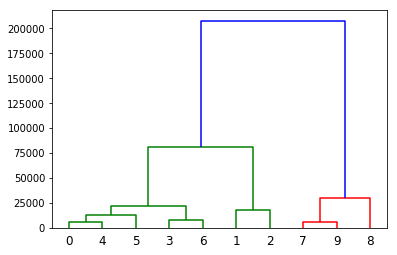

In [31]:
from scipy.cluster.hierarchy import dendrogram
from scgenome.simulation import get_plot_data

plinkage, plot_data = get_plot_data(linkage)
f = dendrogram(plot_data)

In [45]:
hmmcopy_tickets = ['SC-1937']
sample_ids = ['SA1090']

xdata = get_data(hmmcopy_tickets, sample_ids, cached=True)
xcn_data = xdata[0]
xsegs_data = xdata[1]
xmetrics_data = xdata[2]
xalign_metrics_data = xdata[3]

print("cn_data.head()")
display(xcn_data.head())

2019-09-05 14:12:16,540 - INFO - 4104aeca-9102-403d-9902-0edb10de5265 - TokenRequest:Getting token with client credentials.
2019-09-05 14:12:16,791 - INFO - 4104aeca-9102-403d-9902-0edb10de5265 - OAuth2Client:Get Token Server returned this correlation_id: 4104aeca-9102-403d-9902-0edb10de5265


cn_data.head()


,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id
0,1,1,500000,2,-1.000000,NaN,2,SA1090-A96213A-R34-C64,SA1090,A96213A
1,1,500001,1000000,42,-1.000000,NaN,2,SA1090-A96213A-R34-C64,SA1090,A96213A
2,1,1000001,1500000,43,0.598332,3.017390,2,SA1090-A96213A-R34-C64,SA1090,A96213A
3,1,1500001,2000000,42,0.539498,1.936414,2,SA1090-A96213A-R34-C64,SA1090,A96213A
4,1,2000001,2500000,36,0.594508,2.439622,2,SA1090-A96213A-R34-C64,SA1090,A96213A


In [50]:
# Subset small amount of cells
n_cell = 10

xkeep_cells = xcn_data["cell_id"].value_counts().index[0:n_cell]
xsub_cn_data = xcn_data[xcn_data["cell_id"].isin(xkeep_cells)]

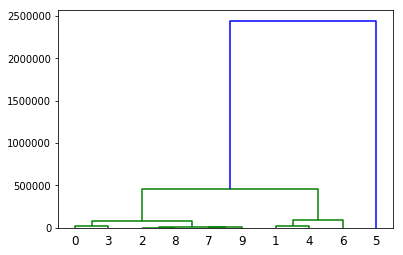

In [52]:
# BHC them!
xlinkage, xclusters, xcell_ids = bayesian_cluster(xsub_cn_data, n_states = xsub_cn_data["state"].max())

xplinkage, xplot_data = get_plot_data(xlinkage)
f = dendrogram(xplot_data)

In [ ]:
# Combine two datasets and see if we can seperate 
cn_data["cell_id"] = "cl1_" + cn_data["cell_id"].astype("str")
xcn_data["cell_id"] = "cl2_" + xcn_data["cell_id"].astype("str")

bi_cn_data = cn_data.append(xcn_data)
bilinkage, biclusters, bicell_ids = bayesian_cluster(bi_cn_data, n_states = bi_cn_data["state"].max())

biplinkage, biplot_data = get_plot_data(bilinkage)
f = dendrogram(biplot_data)

In [ ]:
cl_ids = bicell_ids.str[2]
biplinkage, biplot_data = get_plot_data(bilinkage)
f = dendrogram(biplot_data, lavels=cl_ids)